In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Load the dataset
df = pd.read_csv('pipeline_leak_dataset.csv')

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

2025-09-09 14:31:48.741706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 14:31:48.744814: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 14:31:48.869358: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 14:31:49.339405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-09 14:31:51.102034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

First 5 rows of the dataset:
   Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0               53.35               1105.13       12.87   
1               72.25               1026.31        3.42   
2               65.08                722.96        6.23   
3               60.71               1557.23       11.71   
4               46.19               1304.42        8.58   

   BOPD (barrel of oil produced per day)  \
0                                1378.93   
1                                1028.75   
2                                2017.92   
3                                 558.22   
4                                1280.47   

   BWPD (barrel of water produced per day)  BSW - basic solid and water (%)  \
0                                  2812.62                            75.64   
1                                   919.92                            44.21   
2                                  1212.42                            17.55   
3                                  

Missing values in each column:
Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
CR-corrosion defect                        0
dtype: int64


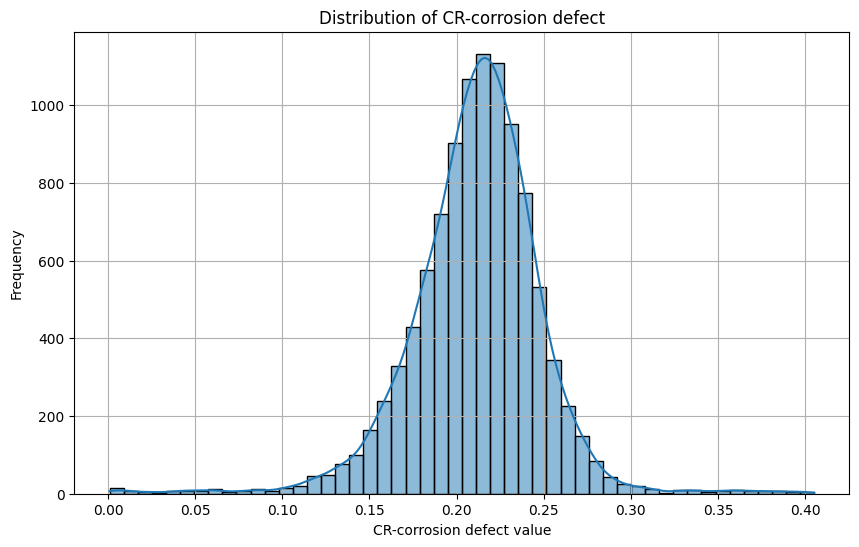

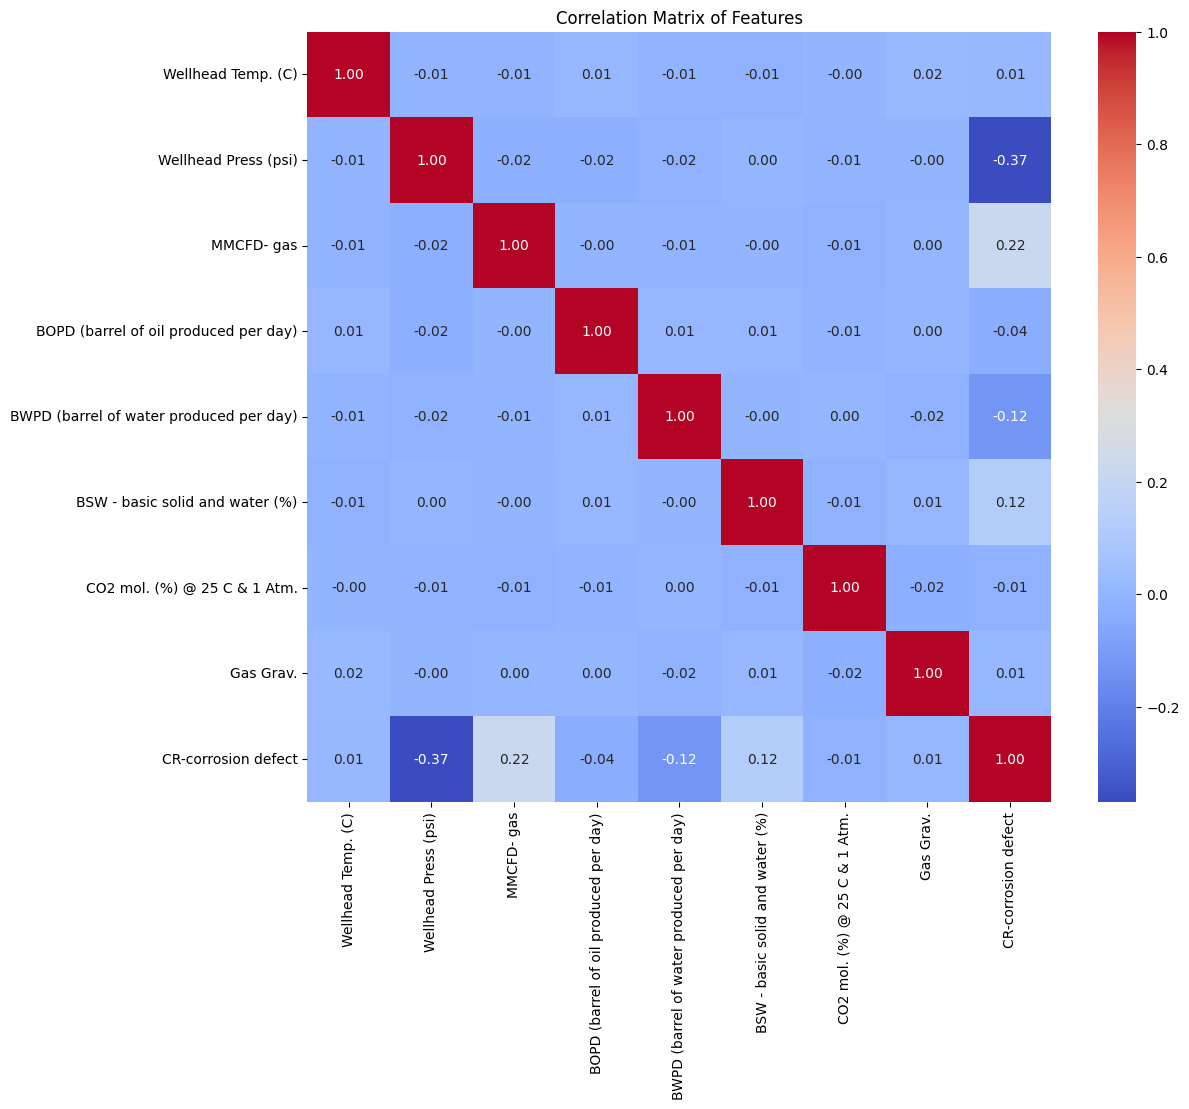

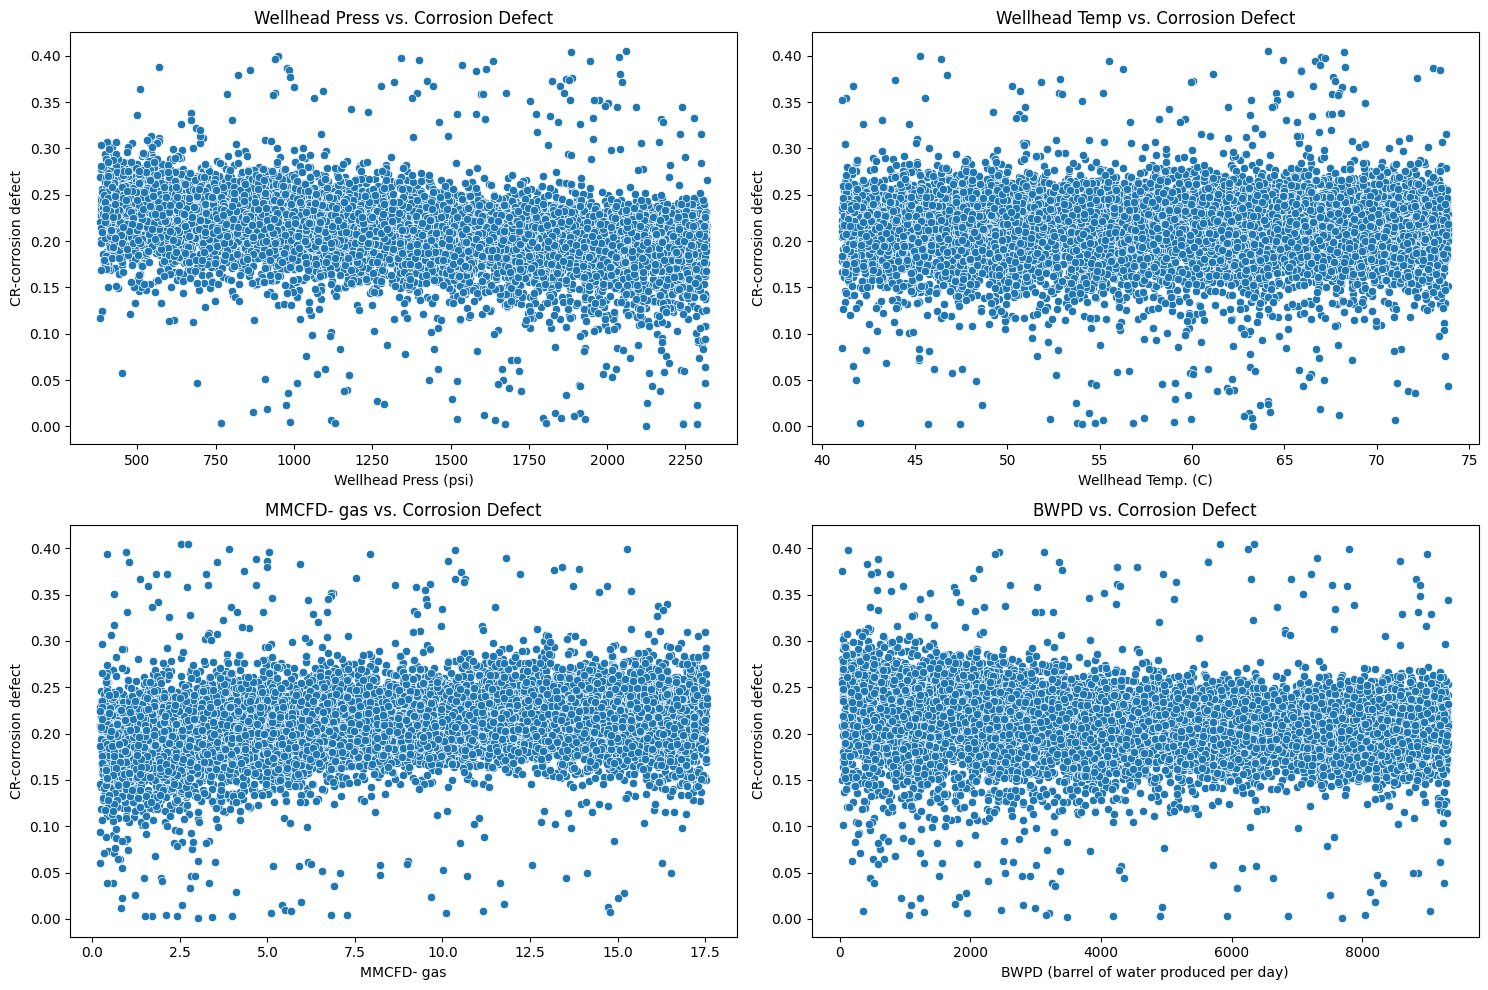

In [2]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Visualize the distribution of the target variable, 'CR-corrosion defect'
plt.figure(figsize=(10, 6))
sns.histplot(df['CR-corrosion defect'], kde=True, bins=50)
plt.title('Distribution of CR-corrosion defect')
plt.xlabel('CR-corrosion defect value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the correlation matrix of the features
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Visualize the relationships between features and the target variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='Wellhead Press (psi)', y='CR-corrosion defect', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Wellhead Press vs. Corrosion Defect')

sns.scatterplot(x='Wellhead Temp. (C)', y='CR-corrosion defect', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Wellhead Temp vs. Corrosion Defect')

sns.scatterplot(x='MMCFD- gas', y='CR-corrosion defect', data=df, ax=axes[1, 0])
axes[1, 0].set_title('MMCFD- gas vs. Corrosion Defect')

sns.scatterplot(x='BWPD (barrel of water produced per day)', y='CR-corrosion defect', data=df, ax=axes[1, 1])
axes[1, 1].set_title('BWPD vs. Corrosion Defect')

plt.tight_layout()
plt.show()

Using the 80th percentile as threshold: 0.2376 for 'CR-corrosion defect'
Applying outlier capping to the following numerical columns: ['Wellhead Temp. (C)', 'Wellhead Press (psi)', 'MMCFD- gas', 'BOPD (barrel of oil produced per day)', 'BWPD (barrel of water produced per day)', 'BSW - basic solid and water (%)', 'CO2 mol. (%) @ 25 C & 1 Atm.', 'Gas Grav.']

Outlier capping applied to numerical columns.


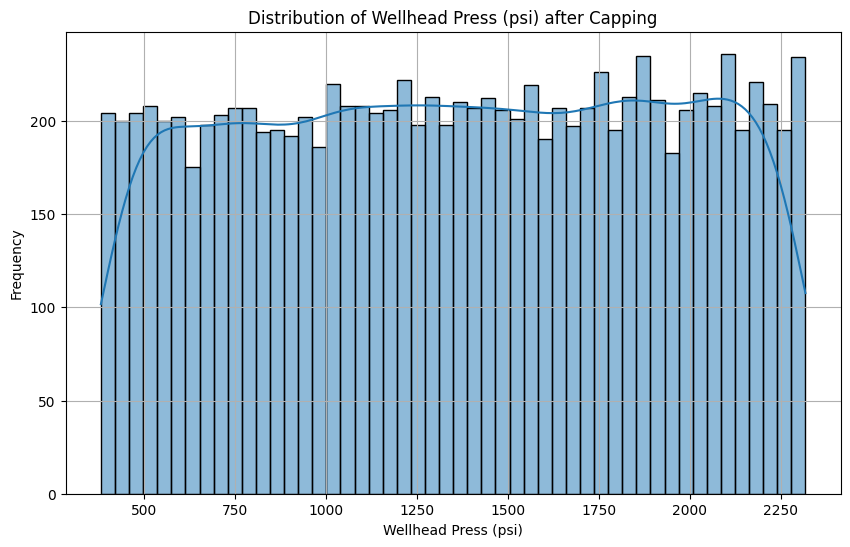


Data dimensions after preprocessing:
X_train shape: (6174, 1, 8)
y_train shape: (6174,)
X_val shape: (2059, 1, 8)
y_val shape: (2059,)
X_test shape: (2059, 1, 8)
y_test shape: (2059,)

Class distribution in the training set (after using 80th percentile threshold):
is_leak
0    0.800615
1    0.199385
Name: proportion, dtype: float64


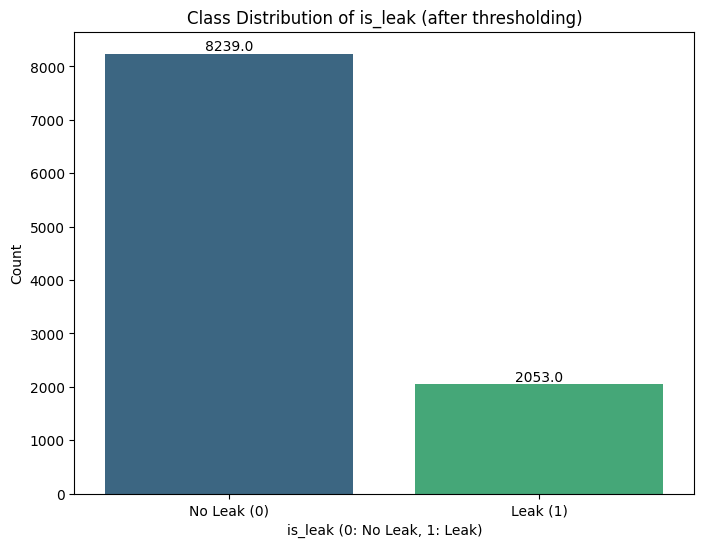

Class distribution after thresholding:
is_leak
0    8239
1    2053
Name: count, dtype: int64

Class distribution (normalized) after thresholding:
is_leak
0    0.800525
1    0.199475
Name: proportion, dtype: float64


In [3]:
# Define the threshold for 'leak' based on a manual value
threshold = df['CR-corrosion defect'].quantile(0.80)
print(f"Using the 80th percentile as threshold: {threshold:.4f} for 'CR-corrosion defect'")

# Create the binary target variable 'is_leak'
df['is_leak'] = (df['CR-corrosion defect'] > threshold).astype(int)

# Drop the original continuous target and any irrelevant features for the model
df_model = df.drop(columns=['CR-corrosion defect'])

# Define features (X) and target (y)
X = df_model.drop('is_leak', axis=1)
y = df_model['is_leak']


# Outlier Detection and Treatment using Capping by Interquartile Range

# Identify numerical columns (excluding the target variable if it's already created)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# If 'CR-corrosion defect' or 'is_leak' are still in numerical_cols, remove them
if 'CR-corrosion defect' in numerical_cols:
    numerical_cols.remove('CR-corrosion defect')
if 'is_leak' in numerical_cols:
    numerical_cols.remove('is_leak')
if 'is_leak_manual' in numerical_cols:
    numerical_cols.remove('is_leak_manual')


print(f"Applying outlier capping to the following numerical columns: {numerical_cols}")

# Apply capping to outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("\nOutlier capping applied to numerical columns.")

# You might want to re-visualize distributions after capping to see the effect
# For example:
plt.figure(figsize=(10, 6))
sns.histplot(df['Wellhead Press (psi)'], kde=True, bins=50)
plt.title('Distribution of Wellhead Press (psi) after Capping')
plt.xlabel('Wellhead Press (psi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training data into training and validation sets (75/25 split from the 80% original)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM, which expects a 3D input: [samples, timesteps, features]
# For this dataset, we treat each row as a single timestep
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print("\nData dimensions after preprocessing:")
print(f"X_train shape: {X_train_reshaped.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val_reshaped.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_reshaped.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the class distribution in the training set
print("\nClass distribution in the training set (after using 80th percentile threshold):")
print(y_train.value_counts(normalize=True))

# Visualize the class distribution of the binary target variable 'is_leak' after thresholding
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_leak', data=df, palette='viridis') # Use 'viridis' palette for different colors
plt.title('Class Distribution of is_leak (after thresholding)')
plt.xlabel('is_leak (0: No Leak, 1: Leak)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Leak (0)', 'Leak (1)'])
# plt.grid(axis='y') # Removed grid

# Add count labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

print("Class distribution after thresholding:")
print(df['is_leak'].value_counts())
print("\nClass distribution (normalized) after thresholding:")
print(df['is_leak'].value_counts(normalize=True))

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7164 - loss: 0.6153 - val_accuracy: 0.8004 - val_loss: 0.4647
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8048 - loss: 0.4539 - val_accuracy: 0.8014 - val_loss: 0.4126
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8142 - loss: 0.4122 - val_accuracy: 0.8247 - val_loss: 0.3869
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8299 - loss: 0.3960 - val_accuracy: 0.8354 - val_loss: 0.3780
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8334 - loss: 0.3885 - val_accuracy: 0.8460 - val_loss: 0.3716
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8368 - loss: 0.3837 - val_accuracy: 0.8460 - val_loss: 0.3666
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8401 - loss: 0.3746 - val_accuracy: 0.8504 - val_loss: 0.3602
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8425 - loss: 0.3718 - val_accuracy: 0.

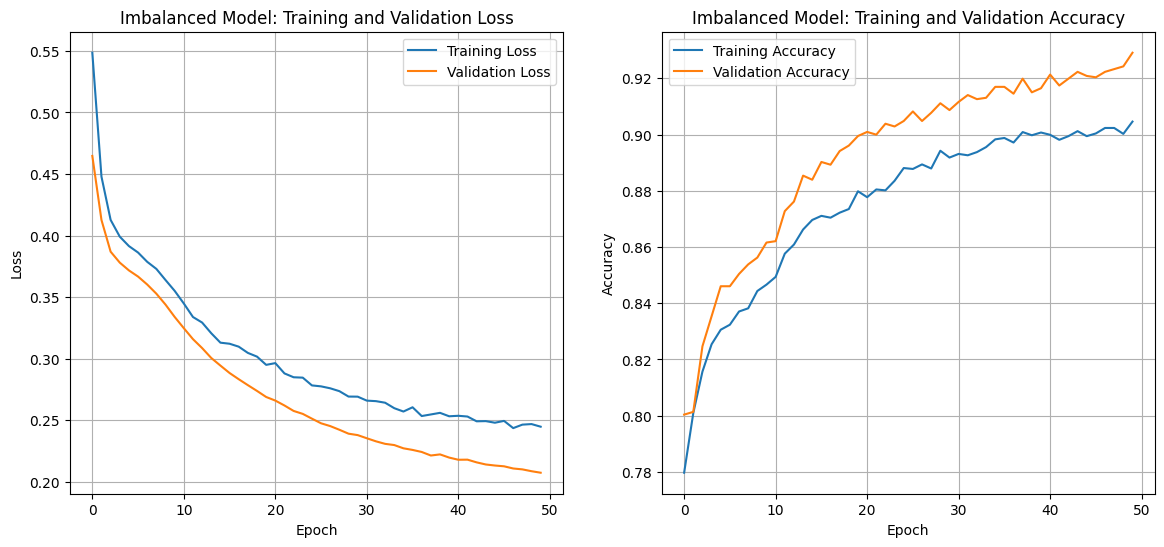


Imbalanced Model Test Accuracy: 0.9310
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Imbalanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1648
           1       0.92      0.72      0.81       411

    accuracy                           0.93      2059
   macro avg       0.93      0.85      0.88      2059
weighted avg       0.93      0.93      0.93      2059



In [4]:
# --- Model 1: Imbalanced Data ---

# Define the LSTM model architecture
model_imbalanced = Sequential()
model_imbalanced.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_imbalanced.add(Dropout(0.2))
model_imbalanced.add(Dense(1, activation='sigmoid'))

# Compile the model
model_imbalanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_imbalanced = model_imbalanced.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_imbalanced.history['loss'], label='Training Loss')
plt.plot(history_imbalanced.history['val_loss'], label='Validation Loss')
plt.title('Imbalanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_imbalanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_imbalanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Imbalanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss, accuracy = model_imbalanced.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nImbalanced Model Test Accuracy: {accuracy:.4f}")

# Generate predictions and classification report
y_pred_imbalanced = (model_imbalanced.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nImbalanced Model Classification Report:")
print(classification_report(y_test, y_pred_imbalanced))

In [5]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Reshape the 3D data back to 2D for SMOTE
X_train_2d = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

# Reshape the data back to 3D for LSTM
X_train_resampled_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])

print("Class distribution in the training set after SMOTE:")
print(y_train_resampled.value_counts(normalize=True))
print(f"Resampled X_train shape: {X_train_resampled_reshaped.shape}")


Class distribution in the training set after SMOTE:
is_leak
0    0.5
1    0.5
Name: proportion, dtype: float64
Resampled X_train shape: (9886, 1, 8)


In [6]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import os
import optuna

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def create_model_for_optuna(l2_rate, n_units, dropout_rate, optimizer):
    """
    Function to create a Keras model for use with Optuna.
    This function is named differently to avoid conflicts with other parts of your code.
    """
    model = Sequential()
    model.add(Input(shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])))
    model.add(LSTM(n_units, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'rmsprop':
        opt = RMSprop()
    else:
        raise ValueError("Invalid optimizer specified.")

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    # Suggest hyperparameters
    l2_rate = trial.suggest_loguniform('l2_rate', 1e-4, 1e-1)
    n_units = trial.suggest_categorical('n_units', [32, 50, 64])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.4)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Create the model using the suggested parameters
    model_imbalanced = create_model_for_optuna(
        l2_rate=l2_rate,
        n_units=n_units,
        dropout_rate=dropout_rate,
        optimizer=optimizer_name
    )

    # Implement Early Stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train the model with the suggested batch size
    history_imbalanced = model_imbalanced.fit(
        X_train_resampled_reshaped,
        y_train_resampled,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val_reshaped, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Return the validation accuracy to be maximized
    return history_imbalanced.history['val_accuracy'][-1]

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Optimize the objective function with a specified number of trials
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Summarize the results
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
print("\nBest parameters found: ", best_params)

[I 2025-09-09 14:32:55,886] A new study created in memory with name: no-name-743abe38-387d-4c91-af08-b44decadc80a
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6673 - loss: 0.7202 - val_accuracy: 0.7067 - val_loss: 0.6598
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7488 - loss: 0.6336 - val_accuracy: 0.7377 - val_loss: 0.5893
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7505 - loss: 0.5800 - val_accuracy: 0.7387 - val_loss: 0.5712
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7573 - loss: 0.5604 - val_accuracy: 0.7421 - val_loss: 0.5570
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7552 - loss: 0.5550 - val_accuracy: 0.7489 - val_loss: 0.5489
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7548 - loss: 0.5454 - val_accuracy: 0.7523 - val_loss: 0.5456
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7595 - loss: 0.5394 - val_accuracy: 0.7610 - val_loss: 0.5354
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.5348 - val_accu

Best trial: 0. Best value: 0.922778:   2%|▏         | 1/50 [00:53<43:19, 53.04s/it]

[I 2025-09-09 14:33:48,928] Trial 0 finished with value: 0.9227780699729919 and parameters: {'l2_rate': 0.0044010765975686095, 'n_units': 64, 'dropout_rate': 0.29611229183163695, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9227780699729919.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6393 - loss: 0.7123 - val_accuracy: 0.7033 - val_loss: 0.6236
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7526 - loss: 0.5933 - val_accuracy: 0.7241 - val_loss: 0.5840
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7492 - loss: 0.5658 - val_accuracy: 0.7358 - val_loss: 0.5685
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7591 - loss: 0.5531 - val_accuracy: 0.7455 - val_loss: 0.5605
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7622 - loss: 0.5392 - val_accuracy: 0.7475 - val_loss: 0.5494
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7669 - loss: 0.5

Best trial: 0. Best value: 0.922778:   4%|▍         | 2/50 [03:09<1:21:48, 102.26s/it]

[I 2025-09-09 14:36:05,646] Trial 1 finished with value: 0.911607563495636 and parameters: {'l2_rate': 0.008306098104694286, 'n_units': 50, 'dropout_rate': 0.39291335716213394, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.9227780699729919.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5875 - loss: 1.2072 - val_accuracy: 0.7460 - val_loss: 0.7113
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6882 - loss: 0.6965 - val_accuracy: 0.6693 - val_loss: 0.6892
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 0.6839 - val_accuracy: 0.7033 - val_loss: 0.6825
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7271 - loss: 0.6764 - val_accuracy: 0.7169 - val_loss: 0.6727
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7384 - loss: 0.6668 - val_accuracy: 0.7266 - val_loss: 0.6597
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7427 - loss: 0.653

Best trial: 0. Best value: 0.922778:   6%|▌         | 3/50 [04:00<1:01:31, 78.54s/it] 

[I 2025-09-09 14:36:55,962] Trial 2 finished with value: 0.8858669400215149 and parameters: {'l2_rate': 0.06070275939202477, 'n_units': 32, 'dropout_rate': 0.2814540468450119, 'optimizer_name': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: 0.9227780699729919.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5726 - loss: 0.7187 - val_accuracy: 0.7261 - val_loss: 0.6705
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7287 - loss: 0.6545 - val_accuracy: 0.7309 - val_loss: 0.6073
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 0.5958 - val_accuracy: 0.7368 - val_loss: 0.5762
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.5720 - val_accuracy: 0.7402 - val_loss: 0.5637
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7562 - loss: 0.5563 - val_accuracy: 0.7484 - val_loss: 0.5533
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7587 - loss: 0.5

Best trial: 0. Best value: 0.922778:   8%|▊         | 4/50 [04:52<52:16, 68.18s/it]  

[I 2025-09-09 14:37:48,246] Trial 3 finished with value: 0.9154929518699646 and parameters: {'l2_rate': 0.0031203482060813315, 'n_units': 32, 'dropout_rate': 0.31786449196020683, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9227780699729919.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6332 - loss: 0.6838 - val_accuracy: 0.7377 - val_loss: 0.6186
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7475 - loss: 0.5904 - val_accuracy: 0.7397 - val_loss: 0.5461
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7482 - loss: 0.5415 - val_accuracy: 0.7489 - val_loss: 0.5310
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7554 - loss: 0.5312 - val_accuracy: 0.7533 - val_loss: 0.5269
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7655 - loss: 0.5173 - val_accuracy: 0.7513 - val_loss: 0.5237
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7718 - loss: 0.5

Best trial: 4. Best value: 0.933949:  10%|█         | 5/50 [06:26<58:04, 77.44s/it]

[I 2025-09-09 14:39:22,115] Trial 4 finished with value: 0.9339485168457031 and parameters: {'l2_rate': 0.0001794751547531271, 'n_units': 50, 'dropout_rate': 0.23661936461784683, 'optimizer_name': 'rmsprop', 'batch_size': 32}. Best is trial 4 with value: 0.9339485168457031.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5628 - loss: 1.0088 - val_accuracy: 0.7523 - val_loss: 0.7020
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7155 - loss: 0.6913 - val_accuracy: 0.7445 - val_loss: 0.6788
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7430 - loss: 0.6766 - val_accuracy: 0.7606 - val_loss: 0.6636
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - loss: 0.6633 - val_accuracy: 0.7329 - val_loss: 0.6529
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7440 - loss: 0.6486 - val_accuracy: 0.7368 - val_loss: 0.6362
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7471 - loss: 

Best trial: 4. Best value: 0.933949:  12%|█▏        | 6/50 [07:17<50:13, 68.48s/it]

[I 2025-09-09 14:40:13,209] Trial 5 finished with value: 0.8737251162528992 and parameters: {'l2_rate': 0.03782227563820628, 'n_units': 32, 'dropout_rate': 0.24976911916142314, 'optimizer_name': 'rmsprop', 'batch_size': 64}. Best is trial 4 with value: 0.9339485168457031.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5786 - loss: 0.6892 - val_accuracy: 0.7382 - val_loss: 0.5936
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7528 - loss: 0.5810 - val_accuracy: 0.7314 - val_loss: 0.5625
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7589 - loss: 0.5497 - val_accuracy: 0.7368 - val_loss: 0.5500
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7581 - loss: 0.5386 - val_accuracy: 0.7363 - val_loss: 0.5476
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7613 - loss: 0.5326 - val_accuracy: 0.7441 - val_loss: 0.5395
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7684 - loss: 0.

Best trial: 4. Best value: 0.933949:  14%|█▍        | 7/50 [08:51<55:09, 76.97s/it]

[I 2025-09-09 14:41:47,638] Trial 6 finished with value: 0.9281204342842102 and parameters: {'l2_rate': 0.0020174456893118564, 'n_units': 50, 'dropout_rate': 0.3286819642271023, 'optimizer_name': 'adam', 'batch_size': 32}. Best is trial 4 with value: 0.9339485168457031.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5949 - loss: 0.6869 - val_accuracy: 0.7023 - val_loss: 0.6467
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.6170 - val_accuracy: 0.7377 - val_loss: 0.5645
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.5543 - val_accuracy: 0.7523 - val_loss: 0.5380
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620 - loss: 0.5340 - val_accuracy: 0.7572 - val_loss: 0.5324
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7743 - loss: 0.5174 - val_accuracy: 0.7649 - val_loss: 0.5129
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7844 - loss: 0.50

Best trial: 4. Best value: 0.933949:  16%|█▌        | 8/50 [09:42<48:06, 68.72s/it]

[I 2025-09-09 14:42:38,688] Trial 7 finished with value: 0.9320058226585388 and parameters: {'l2_rate': 0.00029424389305685505, 'n_units': 32, 'dropout_rate': 0.2550483905854049, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 4 with value: 0.9339485168457031.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6331 - loss: 0.7073 - val_accuracy: 0.7285 - val_loss: 0.6432
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7444 - loss: 0.6242 - val_accuracy: 0.7377 - val_loss: 0.5873
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7538 - loss: 0.5773 - val_accuracy: 0.7450 - val_loss: 0.5619
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7561 - loss: 0.5618 - val_accuracy: 0.7421 - val_loss: 0.5581
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7548 - loss: 0.5495 - val_accuracy: 0.7494 - val_loss: 0.5471
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7619 - loss: 0.5

Best trial: 4. Best value: 0.933949:  18%|█▊        | 9/50 [11:15<52:05, 76.23s/it]

[I 2025-09-09 14:44:11,456] Trial 8 finished with value: 0.9227780699729919 and parameters: {'l2_rate': 0.0038224397980877135, 'n_units': 50, 'dropout_rate': 0.3389466472493161, 'optimizer_name': 'rmsprop', 'batch_size': 32}. Best is trial 4 with value: 0.9339485168457031.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6341 - loss: 0.6825 - val_accuracy: 0.7363 - val_loss: 0.6263
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.5997 - val_accuracy: 0.7387 - val_loss: 0.5496
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.5418 - val_accuracy: 0.7377 - val_loss: 0.5378
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7608 - loss: 0.5302 - val_accuracy: 0.7499 - val_loss: 0.5231
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7690 - loss: 0.5149 - val_accuracy: 0.7567 - val_loss: 0.5125
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7784 - loss: 0

Best trial: 9. Best value: 0.938805:  20%|██        | 10/50 [12:12<46:47, 70.19s/it]

[I 2025-09-09 14:45:08,116] Trial 9 finished with value: 0.9388052225112915 and parameters: {'l2_rate': 0.00012672629504291061, 'n_units': 50, 'dropout_rate': 0.3439649961946586, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6566 - loss: 0.6565 - val_accuracy: 0.7169 - val_loss: 0.5745
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7574 - loss: 0.5437 - val_accuracy: 0.7426 - val_loss: 0.5488
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7664 - loss: 0.5242 - val_accuracy: 0.7538 - val_loss: 0.5384
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7759 - loss: 0.5065 - val_accuracy: 0.7722 - val_loss: 0.5116
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7897 - loss: 0.4891 - val_accuracy: 0.7839 - val_loss: 0.4922
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7952 - loss: 0.4

Best trial: 9. Best value: 0.938805:  22%|██▏       | 11/50 [15:16<1:08:20, 105.14s/it]

[I 2025-09-09 14:48:12,510] Trial 10 finished with value: 0.9373482465744019 and parameters: {'l2_rate': 0.0005956981072075941, 'n_units': 64, 'dropout_rate': 0.37829122520461433, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6761 - loss: 0.6599 - val_accuracy: 0.7290 - val_loss: 0.5650
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7541 - loss: 0.5452 - val_accuracy: 0.7460 - val_loss: 0.5451
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7697 - loss: 0.5295 - val_accuracy: 0.7489 - val_loss: 0.5377
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7762 - loss: 0.5131 - val_accuracy: 0.7533 - val_loss: 0.5282
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7825 - loss: 0.4976 - val_accuracy: 0.7810 - val_loss: 0.4926
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7980 - loss: 0.

Best trial: 9. Best value: 0.938805:  24%|██▍       | 12/50 [17:37<1:13:33, 116.15s/it]

[I 2025-09-09 14:50:33,827] Trial 11 finished with value: 0.9281204342842102 and parameters: {'l2_rate': 0.000743830713766872, 'n_units': 64, 'dropout_rate': 0.380851175657296, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6656 - loss: 0.6516 - val_accuracy: 0.7222 - val_loss: 0.5531
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7558 - loss: 0.5296 - val_accuracy: 0.7489 - val_loss: 0.5212
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7824 - loss: 0.4963 - val_accuracy: 0.7722 - val_loss: 0.4941
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8052 - loss: 0.4674 - val_accuracy: 0.7941 - val_loss: 0.4568
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8163 - loss: 0.4439 - val_accuracy: 0.8145 - val_loss: 0.4247
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8317 - loss: 0.419

Best trial: 9. Best value: 0.938805:  26%|██▌       | 13/50 [19:53<1:15:14, 122.01s/it]

[I 2025-09-09 14:52:49,317] Trial 12 finished with value: 0.9349198937416077 and parameters: {'l2_rate': 0.00010973781393648025, 'n_units': 64, 'dropout_rate': 0.3637911519622416, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6852 - loss: 0.6557 - val_accuracy: 0.7183 - val_loss: 0.5692
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7519 - loss: 0.5422 - val_accuracy: 0.7358 - val_loss: 0.5502
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7716 - loss: 0.5169 - val_accuracy: 0.7513 - val_loss: 0.5245
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7871 - loss: 0.4965 - val_accuracy: 0.7742 - val_loss: 0.4966
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7996 - loss: 0.4743 - val_accuracy: 0.7819 - val_loss: 0.4756
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8099 - loss: 0.

Best trial: 9. Best value: 0.938805:  28%|██▊       | 14/50 [22:26<1:18:46, 131.28s/it]

[I 2025-09-09 14:55:22,026] Trial 13 finished with value: 0.9188926815986633 and parameters: {'l2_rate': 0.0005818652453675424, 'n_units': 64, 'dropout_rate': 0.3562179744818026, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6931 - loss: 0.6576 - val_accuracy: 0.7256 - val_loss: 0.5630
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7585 - loss: 0.5337 - val_accuracy: 0.7479 - val_loss: 0.5429
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7774 - loss: 0.5069 - val_accuracy: 0.7708 - val_loss: 0.5101
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7940 - loss: 0.4851 - val_accuracy: 0.7839 - val_loss: 0.4865
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8043 - loss: 0.4663 - val_accuracy: 0.7950 - val_loss: 0.4618
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8211 - loss: 0.4

Best trial: 9. Best value: 0.938805:  30%|███       | 15/50 [25:29<1:25:40, 146.86s/it]

[I 2025-09-09 14:58:25,002] Trial 14 finished with value: 0.9368625283241272 and parameters: {'l2_rate': 0.0005245290848017444, 'n_units': 50, 'dropout_rate': 0.20715011753157317, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6084 - loss: 0.6940 - val_accuracy: 0.7241 - val_loss: 0.6349
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7469 - loss: 0.6093 - val_accuracy: 0.7387 - val_loss: 0.5615
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7542 - loss: 0.5563 - val_accuracy: 0.7387 - val_loss: 0.5515
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7580 - loss: 0.5406 - val_accuracy: 0.7426 - val_loss: 0.5440
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7625 - loss: 0.5332 - val_accuracy: 0.7484 - val_loss: 0.5357
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7630 - loss: 0.

Best trial: 9. Best value: 0.938805:  32%|███▏      | 16/50 [26:25<1:07:48, 119.67s/it]

[I 2025-09-09 14:59:21,511] Trial 15 finished with value: 0.9354055523872375 and parameters: {'l2_rate': 0.0010846857150032443, 'n_units': 64, 'dropout_rate': 0.36611406768612614, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6555 - loss: 0.6632 - val_accuracy: 0.7188 - val_loss: 0.5706
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7570 - loss: 0.5417 - val_accuracy: 0.7402 - val_loss: 0.5454
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7732 - loss: 0.5164 - val_accuracy: 0.7625 - val_loss: 0.5185
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7885 - loss: 0.4950 - val_accuracy: 0.7732 - val_loss: 0.5005
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7961 - loss: 0.4765 - val_accuracy: 0.7824 - val_loss: 0.4793
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8061 - loss: 0.

Best trial: 9. Best value: 0.938805:  34%|███▍      | 17/50 [29:05<1:12:28, 131.77s/it]

[I 2025-09-09 15:02:01,413] Trial 16 finished with value: 0.9286060929298401 and parameters: {'l2_rate': 0.00026322079675120504, 'n_units': 50, 'dropout_rate': 0.3458056066037292, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 9 with value: 0.9388052225112915.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6657 - loss: 0.6496 - val_accuracy: 0.7101 - val_loss: 0.5660
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7544 - loss: 0.5368 - val_accuracy: 0.7314 - val_loss: 0.5340
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7684 - loss: 0.5183 - val_accuracy: 0.7411 - val_loss: 0.5238
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7765 - loss: 0.5013 - val_accuracy: 0.7630 - val_loss: 0.4969
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7964 - loss: 0.4792 - val_accuracy: 0.7805 - val_loss: 0.4649
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8089 - loss: 0.

Best trial: 17. Best value: 0.939291:  36%|███▌      | 18/50 [31:41<1:14:13, 139.17s/it]

[I 2025-09-09 15:04:37,808] Trial 17 finished with value: 0.9392909407615662 and parameters: {'l2_rate': 0.0001433436291386686, 'n_units': 64, 'dropout_rate': 0.3945617000213889, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.9392909407615662.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6114 - loss: 0.6865 - val_accuracy: 0.7513 - val_loss: 0.6510
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7427 - loss: 0.6347 - val_accuracy: 0.7450 - val_loss: 0.5824
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.5733 - val_accuracy: 0.7479 - val_loss: 0.5461
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7522 - loss: 0.5379 - val_accuracy: 0.7562 - val_loss: 0.5290
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7599 - loss: 0.5279 - val_accuracy: 0.7581 - val_loss: 0.5199
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7667 - loss: 0.

Best trial: 17. Best value: 0.939291:  38%|███▊      | 19/50 [32:35<58:38, 113.50s/it]  

[I 2025-09-09 15:05:31,528] Trial 18 finished with value: 0.9247207641601562 and parameters: {'l2_rate': 0.000117655909717587, 'n_units': 50, 'dropout_rate': 0.3971852597905799, 'optimizer_name': 'rmsprop', 'batch_size': 64}. Best is trial 17 with value: 0.9392909407615662.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6500 - loss: 0.7934 - val_accuracy: 0.6999 - val_loss: 0.6661
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7434 - loss: 0.6418 - val_accuracy: 0.6848 - val_loss: 0.6377
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7586 - loss: 0.5940 - val_accuracy: 0.7096 - val_loss: 0.6017
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7550 - loss: 0.5735 - val_accuracy: 0.7198 - val_loss: 0.5841
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7533 - loss: 0.5615 - val_accuracy: 0.7178 - val_loss: 0.5875
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7587 - loss: 

Best trial: 17. Best value: 0.939291:  40%|████      | 20/50 [34:15<54:37, 109.26s/it]

[I 2025-09-09 15:07:10,893] Trial 19 finished with value: 0.9218066930770874 and parameters: {'l2_rate': 0.018910819741777343, 'n_units': 64, 'dropout_rate': 0.3103719951626934, 'optimizer_name': 'adam', 'batch_size': 32}. Best is trial 17 with value: 0.9392909407615662.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6345 - loss: 0.6971 - val_accuracy: 0.7343 - val_loss: 0.6412
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7474 - loss: 0.6152 - val_accuracy: 0.7445 - val_loss: 0.5607
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7580 - loss: 0.5584 - val_accuracy: 0.7411 - val_loss: 0.5514
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.5393 - val_accuracy: 0.7479 - val_loss: 0.5429
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.5323 - val_accuracy: 0.7591 - val_loss: 0.5297
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7691 - loss: 0.5

Best trial: 17. Best value: 0.939291:  40%|████      | 20/50 [35:11<54:37, 109.26s/it]

[I 2025-09-09 15:08:06,987] Trial 20 finished with value: 0.9373482465744019 and parameters: {'l2_rate': 0.0013952421689644127, 'n_units': 64, 'dropout_rate': 0.28737095763695597, 'optimizer_name': 'adam', 'batch_size': 64}. Best is trial 17 with value: 0.9392909407615662.


Best trial: 17. Best value: 0.939291:  42%|████▏     | 21/50 [35:11<45:05, 93.30s/it] 

Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6467 - loss: 0.6588 - val_accuracy: 0.7193 - val_loss: 0.5615
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7587 - loss: 0.5427 - val_accuracy: 0.7237 - val_loss: 0.5487
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7676 - loss: 0.5223 - val_accuracy: 0.7557 - val_loss: 0.5163
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7858 - loss: 0.5013 - val_accuracy: 0.7649 - val_loss: 0.4943
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7985 - loss: 0.4752 - val_accuracy: 0.7926 - val_loss: 0.4638
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8136 - loss: 0.4570 - val_accuracy: 0.8072 - val_loss: 0.4422
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8226 - loss: 0.4370 - val_accuracy: 0.8247 - val_loss: 0.4156
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8328 - loss: 0.4191 - val_accu

Best trial: 17. Best value: 0.939291:  44%|████▍     | 22/50 [38:10<55:32, 119.03s/it]

[I 2025-09-09 15:11:06,014] Trial 21 finished with value: 0.9324914813041687 and parameters: {'l2_rate': 0.00035053788649251454, 'n_units': 64, 'dropout_rate': 0.377531582848443, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.9392909407615662.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6601 - loss: 0.6524 - val_accuracy: 0.7251 - val_loss: 0.5604
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7641 - loss: 0.5283 - val_accuracy: 0.7538 - val_loss: 0.5254
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7800 - loss: 0.5033 - val_accuracy: 0.7703 - val_loss: 0.5051
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7957 - loss: 0.4828 - val_accuracy: 0.7800 - val_loss: 0.4913
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8069 - loss: 0.4684 - val_accuracy: 0.7892 - val_loss: 0.4651
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8140 - loss: 0.

Best trial: 22. Best value: 0.940262:  46%|████▌     | 23/50 [40:39<57:40, 128.16s/it]

[I 2025-09-09 15:13:35,463] Trial 22 finished with value: 0.9402622580528259 and parameters: {'l2_rate': 0.0001576431103795309, 'n_units': 64, 'dropout_rate': 0.37977778438802157, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 22 with value: 0.9402622580528259.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6541 - loss: 0.6541 - val_accuracy: 0.7402 - val_loss: 0.5503
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7588 - loss: 0.5335 - val_accuracy: 0.7528 - val_loss: 0.5356
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7772 - loss: 0.5060 - val_accuracy: 0.7674 - val_loss: 0.5136
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7939 - loss: 0.4796 - val_accuracy: 0.7902 - val_loss: 0.4767
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8056 - loss: 0.4626 - val_accuracy: 0.7931 - val_loss: 0.4585
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8172 - loss: 0

Best trial: 23. Best value: 0.948519:  48%|████▊     | 24/50 [43:53<1:04:01, 147.74s/it]

[I 2025-09-09 15:16:48,897] Trial 23 finished with value: 0.948518693447113 and parameters: {'l2_rate': 0.000176486148037883, 'n_units': 64, 'dropout_rate': 0.3463745857272472, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6717 - loss: 0.6520 - val_accuracy: 0.7251 - val_loss: 0.5601
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7651 - loss: 0.5296 - val_accuracy: 0.7538 - val_loss: 0.5293
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7842 - loss: 0.5030 - val_accuracy: 0.7766 - val_loss: 0.4974
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7978 - loss: 0.4778 - val_accuracy: 0.7858 - val_loss: 0.4743
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8123 - loss: 0.4571 - val_accuracy: 0.7970 - val_loss: 0.4468
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8192 - loss: 0.439

Best trial: 23. Best value: 0.948519:  50%|█████     | 25/50 [46:39<1:03:56, 153.45s/it]

[I 2025-09-09 15:19:35,653] Trial 24 finished with value: 0.9315201640129089 and parameters: {'l2_rate': 0.0002247065247693778, 'n_units': 64, 'dropout_rate': 0.39929057511323657, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6777 - loss: 0.6542 - val_accuracy: 0.7135 - val_loss: 0.5646
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7618 - loss: 0.5334 - val_accuracy: 0.7358 - val_loss: 0.5373
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7768 - loss: 0.5079 - val_accuracy: 0.7625 - val_loss: 0.5065
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7959 - loss: 0.4768 - val_accuracy: 0.7829 - val_loss: 0.4722
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8090 - loss: 0.4569 - val_accuracy: 0.8014 - val_loss: 0.4408
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8268 - loss: 0.

Best trial: 23. Best value: 0.948519:  52%|█████▏    | 26/50 [49:22<1:02:30, 156.26s/it]

[I 2025-09-09 15:22:18,484] Trial 25 finished with value: 0.931034505367279 and parameters: {'l2_rate': 0.00017839374799752134, 'n_units': 64, 'dropout_rate': 0.36143678182429534, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6596 - loss: 0.6590 - val_accuracy: 0.7300 - val_loss: 0.5604
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7591 - loss: 0.5388 - val_accuracy: 0.7465 - val_loss: 0.5419
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7697 - loss: 0.5158 - val_accuracy: 0.7581 - val_loss: 0.5220
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7866 - loss: 0.4972 - val_accuracy: 0.7649 - val_loss: 0.5085
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7957 - loss: 0.4787 - val_accuracy: 0.7771 - val_loss: 0.4840
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8071 - loss: 0.

Best trial: 23. Best value: 0.948519:  54%|█████▍    | 27/50 [52:45<1:05:14, 170.19s/it]

[I 2025-09-09 15:25:41,168] Trial 26 finished with value: 0.9339485168457031 and parameters: {'l2_rate': 0.0004085851557449754, 'n_units': 64, 'dropout_rate': 0.38178233903058484, 'optimizer_name': 'adam', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6708 - loss: 0.6613 - val_accuracy: 0.7445 - val_loss: 0.5548
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7562 - loss: 0.5412 - val_accuracy: 0.7640 - val_loss: 0.5208
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7624 - loss: 0.5173 - val_accuracy: 0.7746 - val_loss: 0.5090
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7759 - loss: 0.5005 - val_accuracy: 0.7819 - val_loss: 0.4945
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7884 - loss: 0.4824 - val_accuracy: 0.7805 - val_loss: 0.4842
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7972 - loss: 0.

Best trial: 23. Best value: 0.948519:  56%|█████▌    | 28/50 [55:54<1:04:30, 175.93s/it]

[I 2025-09-09 15:28:50,482] Trial 27 finished with value: 0.9465759992599487 and parameters: {'l2_rate': 0.0001011665206719829, 'n_units': 64, 'dropout_rate': 0.3335480145899168, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6726 - loss: 0.6721 - val_accuracy: 0.7421 - val_loss: 0.5689
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7482 - loss: 0.5616 - val_accuracy: 0.7499 - val_loss: 0.5416
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7602 - loss: 0.5364 - val_accuracy: 0.7538 - val_loss: 0.5348
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7641 - loss: 0.5199 - val_accuracy: 0.7688 - val_loss: 0.5164
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7739 - loss: 0.5047 - val_accuracy: 0.7795 - val_loss: 0.5002
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7844 - loss: 

Best trial: 23. Best value: 0.948519:  58%|█████▊    | 29/50 [59:17<1:04:26, 184.10s/it]

[I 2025-09-09 15:32:13,635] Trial 28 finished with value: 0.916949987411499 and parameters: {'l2_rate': 0.0008695983749503149, 'n_units': 64, 'dropout_rate': 0.3222855085415186, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6755 - loss: 0.6619 - val_accuracy: 0.7431 - val_loss: 0.5544
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7508 - loss: 0.5455 - val_accuracy: 0.7562 - val_loss: 0.5272
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7644 - loss: 0.5209 - val_accuracy: 0.7688 - val_loss: 0.5104
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7759 - loss: 0.5015 - val_accuracy: 0.7844 - val_loss: 0.4910
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7863 - loss: 0.4795 - val_accuracy: 0.7955 - val_loss: 0.4616
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8033 - loss: 0

Best trial: 23. Best value: 0.948519:  60%|██████    | 30/50 [1:01:43<57:31, 172.58s/it]  

[I 2025-09-09 15:34:39,350] Trial 29 finished with value: 0.9383195638656616 and parameters: {'l2_rate': 0.00023468242680224342, 'n_units': 64, 'dropout_rate': 0.30348750628092414, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6564 - loss: 0.7040 - val_accuracy: 0.7465 - val_loss: 0.6083
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7475 - loss: 0.5989 - val_accuracy: 0.7348 - val_loss: 0.5741
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7528 - loss: 0.5669 - val_accuracy: 0.7494 - val_loss: 0.5507
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7573 - loss: 0.5546 - val_accuracy: 0.7562 - val_loss: 0.5436
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7549 - loss: 0.5450 - val_accuracy: 0.7640 - val_loss: 0.5347
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7660 - loss

Best trial: 23. Best value: 0.948519:  62%|██████▏   | 31/50 [1:03:44<49:47, 157.25s/it]

[I 2025-09-09 15:36:40,824] Trial 30 finished with value: 0.9096648693084717 and parameters: {'l2_rate': 0.007445171522863655, 'n_units': 64, 'dropout_rate': 0.3329889144407014, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6502 - loss: 0.6633 - val_accuracy: 0.7368 - val_loss: 0.5585
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7573 - loss: 0.5382 - val_accuracy: 0.7591 - val_loss: 0.5217
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7658 - loss: 0.5189 - val_accuracy: 0.7678 - val_loss: 0.5061
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7791 - loss: 0.5010 - val_accuracy: 0.7790 - val_loss: 0.4886
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7932 - loss: 0.4762 - val_accuracy: 0.7863 - val_loss: 0.4703
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8048 - loss: 0

Best trial: 23. Best value: 0.948519:  64%|██████▍   | 32/50 [1:06:12<46:15, 154.19s/it]

[I 2025-09-09 15:39:07,890] Trial 31 finished with value: 0.9422049522399902 and parameters: {'l2_rate': 0.00010647465212015284, 'n_units': 64, 'dropout_rate': 0.350346802851174, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6616 - loss: 0.6623 - val_accuracy: 0.7373 - val_loss: 0.5521
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7495 - loss: 0.5453 - val_accuracy: 0.7411 - val_loss: 0.5291
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7585 - loss: 0.5250 - val_accuracy: 0.7475 - val_loss: 0.5243
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7703 - loss: 0.5068 - val_accuracy: 0.7664 - val_loss: 0.4994
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7863 - loss: 0.4875 - val_accuracy: 0.7834 - val_loss: 0.4723
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7980 - loss: 

Best trial: 23. Best value: 0.948519:  66%|██████▌   | 33/50 [1:09:33<47:40, 168.24s/it]

[I 2025-09-09 15:42:28,919] Trial 32 finished with value: 0.9426906108856201 and parameters: {'l2_rate': 0.00010920485298299647, 'n_units': 64, 'dropout_rate': 0.35252604133903104, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6464 - loss: 0.6674 - val_accuracy: 0.7377 - val_loss: 0.5536
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7589 - loss: 0.5436 - val_accuracy: 0.7455 - val_loss: 0.5255
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7550 - loss: 0.5214 - val_accuracy: 0.7547 - val_loss: 0.5115
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7736 - loss: 0.5013 - val_accuracy: 0.7644 - val_loss: 0.5017
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7924 - loss: 0.4806 - val_accuracy: 0.7882 - val_loss: 0.4622
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8104 - loss

Best trial: 23. Best value: 0.948519:  68%|██████▊   | 34/50 [1:12:57<47:44, 179.03s/it]

[I 2025-09-09 15:45:53,129] Trial 33 finished with value: 0.9354055523872375 and parameters: {'l2_rate': 0.0001064576613306533, 'n_units': 64, 'dropout_rate': 0.3520282630745208, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6500 - loss: 0.6727 - val_accuracy: 0.7305 - val_loss: 0.5835
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7374 - loss: 0.5675 - val_accuracy: 0.7484 - val_loss: 0.5369
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7496 - loss: 0.5423 - val_accuracy: 0.7523 - val_loss: 0.5363
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7608 - loss: 0.5289 - val_accuracy: 0.7659 - val_loss: 0.5203
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7680 - loss: 0.5160 - val_accuracy: 0.7693 - val_loss: 0.5157
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7803 - loss: 

Best trial: 23. Best value: 0.948519:  70%|███████   | 35/50 [1:15:06<40:59, 163.99s/it]

[I 2025-09-09 15:48:02,017] Trial 34 finished with value: 0.9096648693084717 and parameters: {'l2_rate': 0.0003807946836985133, 'n_units': 32, 'dropout_rate': 0.31333379123508753, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6664 - loss: 0.6653 - val_accuracy: 0.7411 - val_loss: 0.5564
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7537 - loss: 0.5457 - val_accuracy: 0.7455 - val_loss: 0.5353
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7569 - loss: 0.5265 - val_accuracy: 0.7635 - val_loss: 0.5144
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7728 - loss: 0.5065 - val_accuracy: 0.7751 - val_loss: 0.5017
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7810 - loss: 0.4921 - val_accuracy: 0.7844 - val_loss: 0.4843
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7933 - loss:

Best trial: 23. Best value: 0.948519:  72%|███████▏  | 36/50 [1:18:12<39:49, 170.69s/it]

[I 2025-09-09 15:51:08,352] Trial 35 finished with value: 0.9412336349487305 and parameters: {'l2_rate': 0.0001916493699088128, 'n_units': 64, 'dropout_rate': 0.3302727246920074, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6168 - loss: 0.9513 - val_accuracy: 0.7159 - val_loss: 0.6845
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7099 - loss: 0.6782 - val_accuracy: 0.7470 - val_loss: 0.6532
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7367 - loss: 0.6478 - val_accuracy: 0.7557 - val_loss: 0.6114
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7378 - loss: 0.6186 - val_accuracy: 0.7596 - val_loss: 0.5804
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7482 - loss: 0.5959 - val_accuracy: 0.7586 - val_loss: 0.5631
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7454 - loss: 

Best trial: 23. Best value: 0.948519:  74%|███████▍  | 37/50 [1:21:38<39:18, 181.41s/it]

[I 2025-09-09 15:54:34,754] Trial 36 finished with value: 0.9067508578300476 and parameters: {'l2_rate': 0.09032626987301895, 'n_units': 64, 'dropout_rate': 0.2931086324539355, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6071 - loss: 0.6785 - val_accuracy: 0.7547 - val_loss: 0.6064
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7317 - loss: 0.5998 - val_accuracy: 0.7329 - val_loss: 0.5534
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7503 - loss: 0.5509 - val_accuracy: 0.7290 - val_loss: 0.5390
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7502 - loss: 0.5362 - val_accuracy: 0.7407 - val_loss: 0.5259
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7608 - loss: 0.5288 - val_accuracy: 0.7479 - val_loss: 0.5212
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7662 - loss: 0.

Best trial: 23. Best value: 0.948519:  76%|███████▌  | 38/50 [1:23:21<31:32, 157.69s/it]

[I 2025-09-09 15:56:17,106] Trial 37 finished with value: 0.9242350459098816 and parameters: {'l2_rate': 0.00010007636692865091, 'n_units': 32, 'dropout_rate': 0.34944764163715947, 'optimizer_name': 'rmsprop', 'batch_size': 32}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6513 - loss: 0.6818 - val_accuracy: 0.7334 - val_loss: 0.5897
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7531 - loss: 0.5725 - val_accuracy: 0.7475 - val_loss: 0.5492
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7535 - loss: 0.5441 - val_accuracy: 0.7576 - val_loss: 0.5373
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7612 - loss: 0.5342 - val_accuracy: 0.7644 - val_loss: 0.5293
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7643 - loss: 0.5216 - val_accuracy: 0.7708 - val_loss: 0.5141
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7731 - loss

Best trial: 23. Best value: 0.948519:  78%|███████▊  | 39/50 [1:26:16<29:52, 162.99s/it]

[I 2025-09-09 15:59:12,478] Trial 38 finished with value: 0.9213210344314575 and parameters: {'l2_rate': 0.002004790726173288, 'n_units': 64, 'dropout_rate': 0.31984017778684126, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6394 - loss: 0.6754 - val_accuracy: 0.7455 - val_loss: 0.6039
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7363 - loss: 0.5936 - val_accuracy: 0.7353 - val_loss: 0.5478
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7461 - loss: 0.5510 - val_accuracy: 0.7387 - val_loss: 0.5331
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - loss: 0.5382 - val_accuracy: 0.7436 - val_loss: 0.5295
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7605 - loss: 0.5265 - val_accuracy: 0.7504 - val_loss: 0.5203
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7652 - loss: 

Best trial: 23. Best value: 0.948519:  80%|████████  | 40/50 [1:27:59<24:08, 144.82s/it]

[I 2025-09-09 16:00:54,904] Trial 39 finished with value: 0.9077221751213074 and parameters: {'l2_rate': 0.00017407072886431175, 'n_units': 32, 'dropout_rate': 0.3351169437630887, 'optimizer_name': 'rmsprop', 'batch_size': 32}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7117 - loss: 0.6585 - val_accuracy: 0.7377 - val_loss: 0.5533
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7522 - loss: 0.5432 - val_accuracy: 0.7436 - val_loss: 0.5332
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7628 - loss: 0.5222 - val_accuracy: 0.7567 - val_loss: 0.5184
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7742 - loss: 0.5032 - val_accuracy: 0.7771 - val_loss: 0.4960
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7889 - loss: 0.4840 - val_accuracy: 0.7824 - val_loss: 0.4851
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8008 - loss:

Best trial: 23. Best value: 0.948519:  82%|████████▏ | 41/50 [1:31:17<24:09, 161.06s/it]

[I 2025-09-09 16:04:13,858] Trial 40 finished with value: 0.9324914813041687 and parameters: {'l2_rate': 0.00028358768019796563, 'n_units': 64, 'dropout_rate': 0.27314037121119766, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6675 - loss: 0.6639 - val_accuracy: 0.7363 - val_loss: 0.5582
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7498 - loss: 0.5468 - val_accuracy: 0.7533 - val_loss: 0.5267
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7658 - loss: 0.5226 - val_accuracy: 0.7654 - val_loss: 0.5109
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7824 - loss: 0.4989 - val_accuracy: 0.7863 - val_loss: 0.4816
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7977 - loss: 0.4715 - val_accuracy: 0.7926 - val_loss: 0.4606
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8153 - loss

Best trial: 23. Best value: 0.948519:  84%|████████▍ | 42/50 [1:34:28<22:38, 169.87s/it]

[I 2025-09-09 16:07:24,280] Trial 41 finished with value: 0.934434175491333 and parameters: {'l2_rate': 0.0002286529355506522, 'n_units': 64, 'dropout_rate': 0.3283132337810193, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6891 - loss: 0.6605 - val_accuracy: 0.7373 - val_loss: 0.5580
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7523 - loss: 0.5471 - val_accuracy: 0.7508 - val_loss: 0.5307
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7651 - loss: 0.5248 - val_accuracy: 0.7596 - val_loss: 0.5177
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7718 - loss: 0.5107 - val_accuracy: 0.7683 - val_loss: 0.5114
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7779 - loss: 0.4981 - val_accuracy: 0.7766 - val_loss: 0.4988
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7878 - loss: 0

Best trial: 23. Best value: 0.948519:  86%|████████▌ | 43/50 [1:37:32<20:17, 173.99s/it]

[I 2025-09-09 16:10:27,887] Trial 42 finished with value: 0.9295774698257446 and parameters: {'l2_rate': 0.0002014187045825453, 'n_units': 64, 'dropout_rate': 0.36966514997337185, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6725 - loss: 0.6629 - val_accuracy: 0.7402 - val_loss: 0.5530
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7509 - loss: 0.5421 - val_accuracy: 0.7397 - val_loss: 0.5311
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7619 - loss: 0.5154 - val_accuracy: 0.7518 - val_loss: 0.5193
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7795 - loss: 0.4986 - val_accuracy: 0.7746 - val_loss: 0.4954
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7932 - loss: 0.4755 - val_accuracy: 0.7839 - val_loss: 0.4677
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8055 - loss:

Best trial: 23. Best value: 0.948519:  88%|████████▊ | 44/50 [1:40:51<18:10, 181.70s/it]

[I 2025-09-09 16:13:47,564] Trial 43 finished with value: 0.9417192935943604 and parameters: {'l2_rate': 0.000144317573611792, 'n_units': 64, 'dropout_rate': 0.34149634866921263, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6916 - loss: 0.6570 - val_accuracy: 0.7377 - val_loss: 0.5468
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7537 - loss: 0.5410 - val_accuracy: 0.7445 - val_loss: 0.5293
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7624 - loss: 0.5245 - val_accuracy: 0.7586 - val_loss: 0.5096
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7748 - loss: 0.5017 - val_accuracy: 0.7698 - val_loss: 0.4982
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7863 - loss: 0.4833 - val_accuracy: 0.7863 - val_loss: 0.4735
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8009 - loss: 

Best trial: 23. Best value: 0.948519:  90%|█████████ | 45/50 [1:44:15<15:42, 188.43s/it]

[I 2025-09-09 16:17:11,694] Trial 44 finished with value: 0.9324914813041687 and parameters: {'l2_rate': 0.00015111978196031097, 'n_units': 64, 'dropout_rate': 0.34447596276982395, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6441 - loss: 0.6665 - val_accuracy: 0.7441 - val_loss: 0.5518
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7562 - loss: 0.5434 - val_accuracy: 0.7499 - val_loss: 0.5179
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7613 - loss: 0.5193 - val_accuracy: 0.7513 - val_loss: 0.5153
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7730 - loss: 0.5040 - val_accuracy: 0.7630 - val_loss: 0.5053
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7881 - loss: 0.4857 - val_accuracy: 0.7761 - val_loss: 0.4801
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7979 - loss

Best trial: 23. Best value: 0.948519:  92%|█████████▏| 46/50 [1:47:11<12:18, 184.52s/it]

[I 2025-09-09 16:20:07,082] Trial 45 finished with value: 0.9286060929298401 and parameters: {'l2_rate': 0.00010103480155649392, 'n_units': 64, 'dropout_rate': 0.35679191910949853, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6444 - loss: 0.7510 - val_accuracy: 0.7013 - val_loss: 0.6591
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7423 - loss: 0.6328 - val_accuracy: 0.7368 - val_loss: 0.6003
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7505 - loss: 0.5885 - val_accuracy: 0.7557 - val_loss: 0.5675
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7511 - loss: 0.5667 - val_accuracy: 0.7654 - val_loss: 0.5489
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7549 - loss: 0.5523 - val_accuracy: 0.7766 - val_loss: 0.5316
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7617 - loss

Best trial: 23. Best value: 0.948519:  94%|█████████▍| 47/50 [1:50:54<09:48, 196.03s/it]

[I 2025-09-09 16:23:49,985] Trial 46 finished with value: 0.9247207641601562 and parameters: {'l2_rate': 0.021371181741570797, 'n_units': 64, 'dropout_rate': 0.34174103191587524, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6054 - loss: 0.6825 - val_accuracy: 0.7567 - val_loss: 0.6074
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7314 - loss: 0.5998 - val_accuracy: 0.7343 - val_loss: 0.5574
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7495 - loss: 0.5562 - val_accuracy: 0.7334 - val_loss: 0.5416
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7505 - loss: 0.5418 - val_accuracy: 0.7271 - val_loss: 0.5422
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7611 - loss: 0.5366 - val_accuracy: 0.7382 - val_loss: 0.5328
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7640 - loss: 

Best trial: 23. Best value: 0.948519:  96%|█████████▌| 48/50 [1:52:06<05:17, 158.82s/it]

[I 2025-09-09 16:25:01,966] Trial 47 finished with value: 0.9004371166229248 and parameters: {'l2_rate': 0.0004947146067895929, 'n_units': 32, 'dropout_rate': 0.30333640339280526, 'optimizer_name': 'rmsprop', 'batch_size': 32}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6612 - loss: 0.6656 - val_accuracy: 0.7465 - val_loss: 0.5618
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7527 - loss: 0.5477 - val_accuracy: 0.7664 - val_loss: 0.5233
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7661 - loss: 0.5248 - val_accuracy: 0.7742 - val_loss: 0.5136
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7816 - loss: 0.5027 - val_accuracy: 0.7800 - val_loss: 0.5001
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7943 - loss: 0.4862 - val_accuracy: 0.7882 - val_loss: 0.4840
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8022 - loss:

Best trial: 23. Best value: 0.948519:  98%|█████████▊| 49/50 [1:54:52<02:41, 161.14s/it]

[I 2025-09-09 16:27:48,536] Trial 48 finished with value: 0.9349198937416077 and parameters: {'l2_rate': 0.0002931854473890041, 'n_units': 64, 'dropout_rate': 0.37202290334562643, 'optimizer_name': 'rmsprop', 'batch_size': 16}. Best is trial 23 with value: 0.948518693447113.
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6132 - loss: 0.6840 - val_accuracy: 0.7717 - val_loss: 0.6392
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7413 - loss: 0.6311 - val_accuracy: 0.7382 - val_loss: 0.5770
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7516 - loss: 0.5678 - val_accuracy: 0.7368 - val_loss: 0.5483
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7574 - loss: 0.5400 - val_accuracy: 0.7479 - val_loss: 0.5290
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7652 - loss: 0.5255 - val_accuracy: 0.7499 - val_loss: 0.5216
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7724 - loss:

Best trial: 23. Best value: 0.948519:  98%|█████████▊| 49/50 [1:55:54<02:41, 161.14s/it]

[I 2025-09-09 16:28:50,152] Trial 49 finished with value: 0.9179213047027588 and parameters: {'l2_rate': 0.00014122045965703732, 'n_units': 50, 'dropout_rate': 0.3248629141131688, 'optimizer_name': 'rmsprop', 'batch_size': 64}. Best is trial 23 with value: 0.948518693447113.


Best trial: 23. Best value: 0.948519: 100%|██████████| 50/50 [1:55:54<00:00, 139.09s/it]


Best trial:
  Validation Accuracy: 0.9485
  Best hyperparameters: 
    l2_rate: 0.000176486148037883
    n_units: 64
    dropout_rate: 0.3463745857272472
    optimizer_name: adam
    batch_size: 16

Best parameters found:  {'l2_rate': 0.000176486148037883, 'n_units': 64, 'dropout_rate': 0.3463745857272472, 'optimizer_name': 'adam', 'batch_size': 16}


Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6748 - loss: 0.6534 - val_accuracy: 0.7246 - val_loss: 0.5585
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7582 - loss: 0.5326 - val_accuracy: 0.7460 - val_loss: 0.5373
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7743 - loss: 0.5074 - val_accuracy: 0.7708 - val_loss: 0.5032
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7948 - loss: 0.4825 - val_accuracy: 0.7800 - val_loss: 0.4834
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8025 - loss: 0.4577 - val_accuracy: 0.7907 - val_loss: 0.4597
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8173 - loss: 0.4419 - val_accuracy: 0.8193 - val_loss: 0.4247
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8317 - loss: 0.4208 - val_accuracy: 0.8378 - val_loss: 0.3991
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8412 - loss: 0.4064 - val_ac

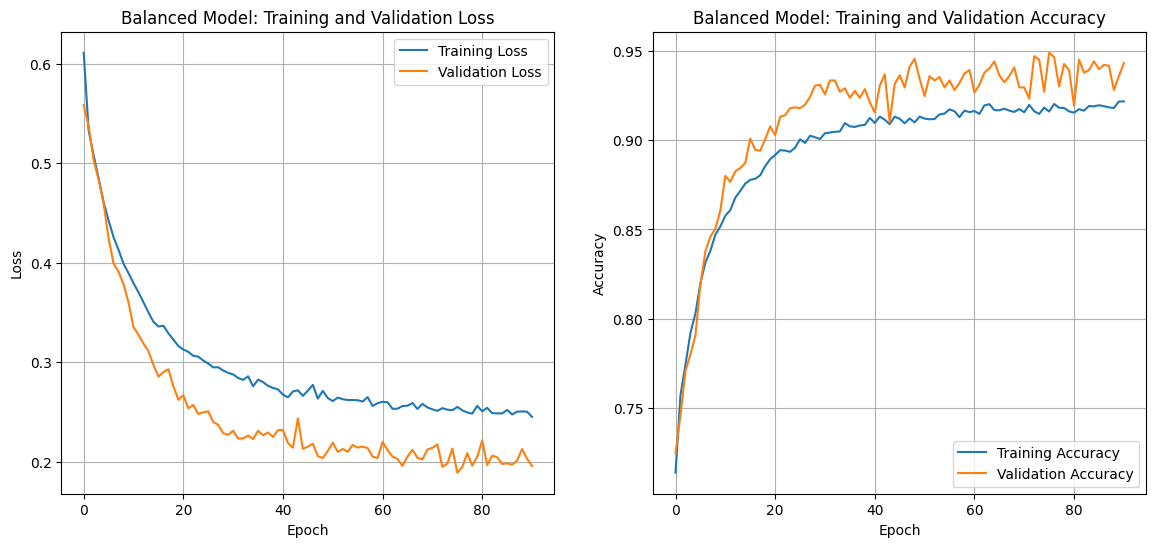

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Optimal Threshold: 0.6668
Final Model Validation Accuracy: 94.90%
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report with Optimal Threshold (F1 score):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1648
           1       0.97      0.85      0.91       411

    accuracy                           0.97      2059
   macro avg       0.97      0.92      0.94      2059
weighted avg       0.97      0.97      0.96      2059



In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Extract the best hyperparameters from the Optuna results
best_l2_rate = best_params['l2_rate']
best_n_units = best_params['n_units']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = best_params['batch_size']
best_optimizer_name = best_params['optimizer_name']


# Define the final model architecture with the best hyperparameters
final_model = Sequential()
final_model.add(Input(shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])))
final_model.add(LSTM(
    units=best_n_units,
    activation='relu',
    kernel_regularizer=l2(best_l2_rate)
))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(1, activation='sigmoid'))

# Choose the best optimizer from the dictionary
if best_optimizer_name == 'adam':
    opt = Adam()
elif best_optimizer_name == 'rmsprop':
    opt = RMSprop()
else:
    raise ValueError("Invalid optimizer name from best_params")

# Compile the final model
final_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the final model with the best parameters
final_history = final_model.fit(
    X_train_resampled_reshaped,
    y_train_resampled,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Balanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Balanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Make probability predictions on the validation set
y_pred_probs = final_model.predict(X_val_reshaped)

def find_best_threshold(y_true, y_pred_probs):
    """
    Finds the optimal threshold that maximizes the F1-score.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Handle NaN values that can occur when precision + recall is zero
    f1_scores = np.nan_to_num(f1_scores)
    
    optimal_threshold_index = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    return optimal_threshold

# Find the best threshold using the validation set
best_threshold = find_best_threshold(y_val, y_pred_probs)
print(f"Optimal Threshold: {best_threshold:.4f}")


# Evaluate the final model on the validation set
val_loss, val_accuracy = final_model.evaluate(X_val_reshaped, y_val, verbose=0)
print(f"Final Model Validation Accuracy: {val_accuracy * 100:.2f}%")

# Make probability predictions on the test set
y_test_pred_probs = final_model.predict(X_test_reshaped)

# Apply the optimal threshold to get final binary predictions
y_pred_with_best_threshold = (y_test_pred_probs > best_threshold).astype("int32")

# Generate the classification report
print("\nClassification Report with Optimal Threshold (F1 score):")
print(classification_report(y_test, y_pred_with_best_threshold))


In [ ]:

# Define the LSTM model architecture (same as before for a fair comparison)
model_balanced = Sequential()
model_balanced.add(LSTM(50, activation='relu', input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])))
model_balanced.add(Dropout(0.2))
model_balanced.add(Dense(1, activation='sigmoid'))

# Compile the model
model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the balanced data
history_balanced = model_balanced.fit(
    X_train_resampled_reshaped, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['loss'], label='Training Loss')
plt.plot(history_balanced.history['val_loss'], label='Validation Loss')
plt.title('Balanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_balanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Balanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss_balanced, accuracy_balanced = model_balanced.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nBalanced Model Test Accuracy: {accuracy_balanced:.4f}")

# Generate predictions and classification report
y_pred_balanced = (model_balanced.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nBalanced Model Classification Report:")
print(classification_report(y_test, y_pred_balanced))

Class distribution in the training set after SMOTE:
is_leak
0    0.5
1    0.5
Name: proportion, dtype: float64
Resampled X_train shape: (9886, 1, 8)
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6374 - loss: 0.6705 - val_accuracy: 0.7314 - val_loss: 0.5682
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7533 - loss: 0.5427 - val_accuracy: 0.7557 - val_loss: 0.5250
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7700 - loss: 0.5087 - val_accuracy: 0.7644 - val_loss: 0.5083
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7794 - loss: 0.4856 - val_accuracy: 0.7829 - val_loss: 0.4763
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7977 - loss: 0.4590 - val_accuracy: 0.7887 - val_loss: 0.4535
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8117 - loss: 0.4392 - val_accuracy: 0.8120 - val_loss: 0.4245
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8243 - loss: 0.41

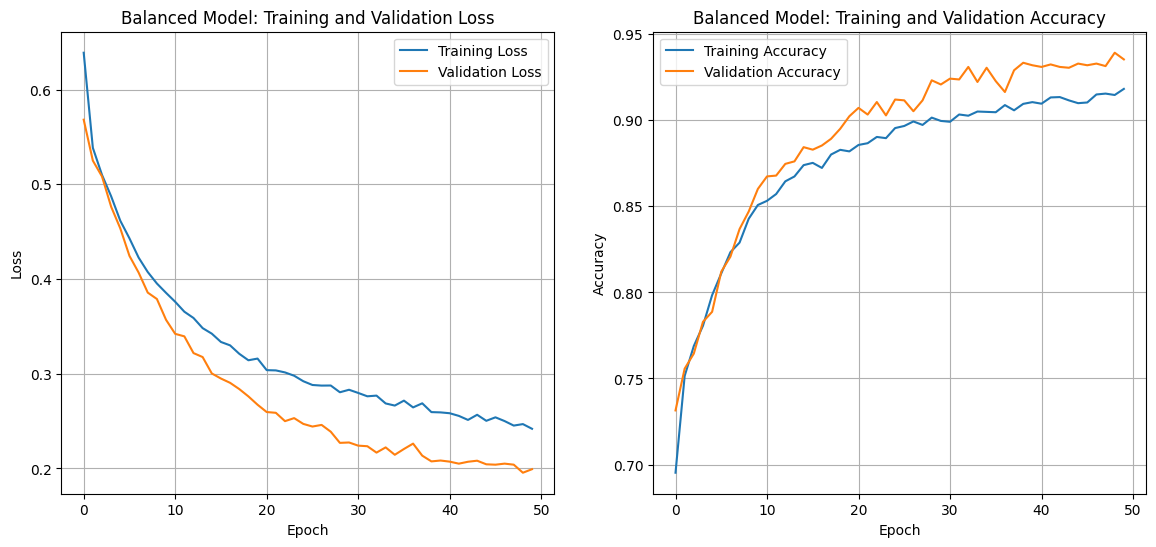


Balanced Model Test Accuracy: 0.9422
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Balanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1648
           1       0.80      0.94      0.87       411

    accuracy                           0.94      2059
   macro avg       0.89      0.94      0.92      2059
weighted avg       0.95      0.94      0.94      2059



In [28]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Reshape the 3D data back to 2D for SMOTE
X_train_2d = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

# Reshape the data back to 3D for LSTM
X_train_resampled_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])

print("Class distribution in the training set after SMOTE:")
print(y_train_resampled.value_counts(normalize=True))
print(f"Resampled X_train shape: {X_train_resampled_reshaped.shape}")

# --- Model 2: Balanced Data ---
# Define the LSTM model architecture (same as before for a fair comparison)
model_balanced = Sequential()
model_balanced.add(LSTM(50, activation='relu', input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2])))
model_balanced.add(Dropout(0.2))
model_balanced.add(Dense(1, activation='sigmoid'))

# Compile the model
model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the balanced data
history_balanced = model_balanced.fit(
    X_train_resampled_reshaped, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['loss'], label='Training Loss')
plt.plot(history_balanced.history['val_loss'], label='Validation Loss')
plt.title('Balanced Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_balanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Balanced Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss_balanced, accuracy_balanced = model_balanced.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nBalanced Model Test Accuracy: {accuracy_balanced:.4f}")

# Generate predictions and classification report
y_pred_balanced = (model_balanced.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nBalanced Model Classification Report:")
print(classification_report(y_test, y_pred_balanced))

Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7150 - loss: 0.5684 - val_accuracy: 0.8154 - val_loss: 0.4241
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8209 - loss: 0.4247 - val_accuracy: 0.8849 - val_loss: 0.3190
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8645 - loss: 0.3467 - val_accuracy: 0.9116 - val_loss: 0.2632
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8815 - loss: 0.3116 - val_accuracy: 0.9155 - val_loss: 0.2497
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8941 - loss: 0.2859 - val_accuracy: 0.9199 - val_loss: 0.2442
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9000 - loss: 0.2738 - val_accuracy: 0.9354 - val_loss: 0.2195
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9040 - loss: 0.2576 - val_accuracy: 0.9417 - val_loss: 0.1994
Epoch 8/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9104 - loss: 0.2609 - val_accuracy: 0.

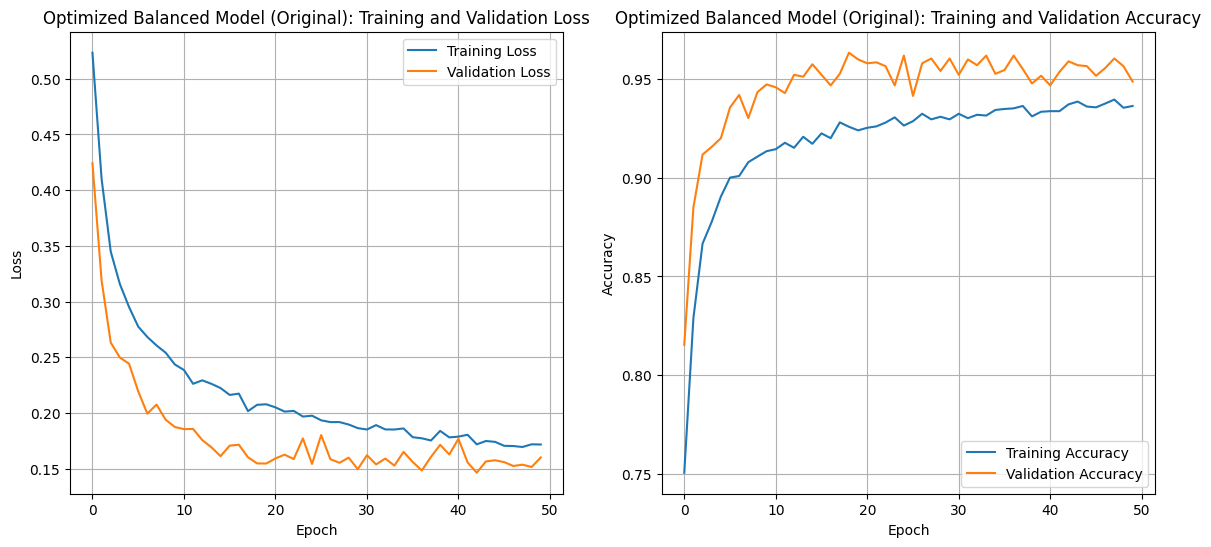


Optimized Balanced Model (Original) Test Accuracy: 0.9665
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Optimized Balanced Model (Original) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1648
           1       0.92      0.92      0.92       411

    accuracy                           0.97      2059
   macro avg       0.95      0.95      0.95      2059
weighted avg       0.97      0.97      0.97      2059



In [29]:
from tensorflow.keras.optimizers import Adam
# Removed import of l2 and compute_class_weight

# Assuming X_train_resampled_reshaped, y_train_resampled, X_val_reshaped, y_val, X_test_reshaped, y_test are defined

# Class weights calculation is removed as it's not used
# Removed class_weights and class_weight_dict calculation


# --- Model 3: Balanced Data with Optimal Hyperparameters (Original Optimized) ---
# Define the LSTM model architecture with optimal hyperparameters (removed L2 regularization)
model_optimized = Sequential()
model_optimized.add(LSTM(128, activation='relu', input_shape=(X_train_resampled_reshaped.shape[1], X_train_resampled_reshaped.shape[2]))) # Removed kernel_regularizer
model_optimized.add(Dropout(0.3))
model_optimized.add(Dense(1, activation='sigmoid'))

# Compile the model with the optimal learning rate
optimizer = Adam(learning_rate=0.01)
model_optimized.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the balanced data without class weights
history_optimized = model_optimized.fit(
    X_train_resampled_reshaped, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
    # Removed class_weight=class_weight_dict
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_optimized.history['loss'], label='Training Loss')
plt.plot(history_optimized.history['val_loss'], label='Validation Loss')
plt.title('Optimized Balanced Model (Original): Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_optimized.history['accuracy'], label='Training Accuracy')
plt.plot(history_optimized.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized Balanced Model (Original): Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Evaluate the model on the test set
loss_optimized, accuracy_optimized = model_optimized.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nOptimized Balanced Model (Original) Test Accuracy: {accuracy_optimized:.4f}")

# Generate predictions and classification report
y_pred_optimized = (model_optimized.predict(X_test_reshaped) > 0.5).astype("int32")
print("\nOptimized Balanced Model (Original) Classification Report:")
print(classification_report(y_test, y_pred_optimized))


--- Finding Optimal Threshold for F1 Score ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


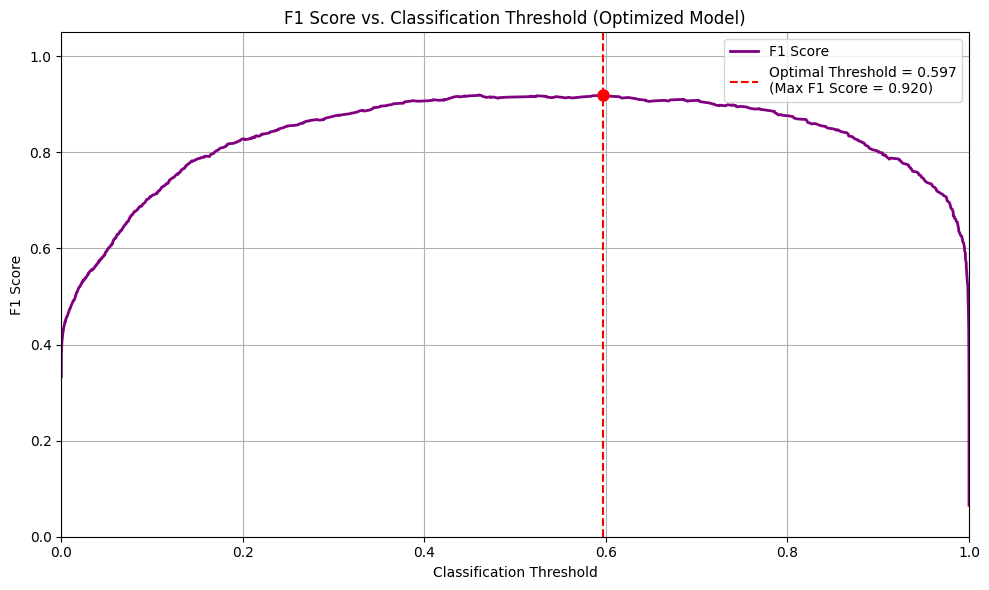

The optimal classification threshold for maximizing F1 score using the optimized model is approximately 0.597, which yields an F1 score of 0.920.

Optimized Balanced Model Classification Report (with Optimal Threshold):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1648
           1       0.94      0.90      0.92       411

    accuracy                           0.97      2059
   macro avg       0.96      0.94      0.95      2059
weighted avg       0.97      0.97      0.97      2059



In [30]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib

print("\n--- Finding Optimal Threshold for F1 Score ---")

# Make predictions on the test set using the optimized model
y_probs_optimized = model_optimized.predict(X_test_reshaped).ravel()

# Calculate precision and recall for all possible thresholds
precision_optimized, recall_optimized, thresholds_optimized = precision_recall_curve(y_test, y_probs_optimized)

# Calculate the F1 score for each threshold
f1_scores_optimized = (2 * precision_optimized * recall_optimized) / (precision_optimized + recall_optimized)
f1_scores_optimized[np.isnan(f1_scores_optimized)] = 0 # Handle potential NaN values

# Find the threshold that corresponds to the maximum F1 score
optimal_f1_threshold_idx_optimized = np.argmax(f1_scores_optimized)
optimal_f1_threshold_optimized = thresholds_optimized[optimal_f1_threshold_idx_optimized]
max_f1_optimized = f1_scores_optimized[optimal_f1_threshold_idx_optimized]

# --- Plotting ---

plt.figure(figsize=(10, 6))

# Plot F1 Score vs. Threshold
plt.plot(thresholds_optimized, f1_scores_optimized[:-1], label='F1 Score', color='purple', lw=2)

# Highlight the optimal F1 threshold
plt.axvline(x=optimal_f1_threshold_optimized, color='red', linestyle='--',
            label=f'Optimal Threshold = {optimal_f1_threshold_optimized:.3f}\n(Max F1 Score = {max_f1_optimized:.3f})')
plt.plot(optimal_f1_threshold_optimized, max_f1_optimized, 'ro', markersize=8) # Mark the optimal F1 point

plt.xlabel('Classification Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold (Optimized Model)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05) # Set y-axis limits
plt.xlim(0, 1.0) # Set x-axis limits
plt.tight_layout()
plt.show()

print(f"The optimal classification threshold for maximizing F1 score using the optimized model is approximately {optimal_f1_threshold_optimized:.3f}, which yields an F1 score of {max_f1_optimized:.3f}.")

# Re-evaluate the optimized model with the optimal threshold
y_pred_optimized_thresholded = (y_probs_optimized > optimal_f1_threshold_optimized).astype("int32")

print("\nOptimized Balanced Model Classification Report (with Optimal Threshold):")
print(classification_report(y_test, y_pred_optimized_thresholded))


--- Evaluating Optimized Balanced Model on Test Set with Optimal Threshold ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


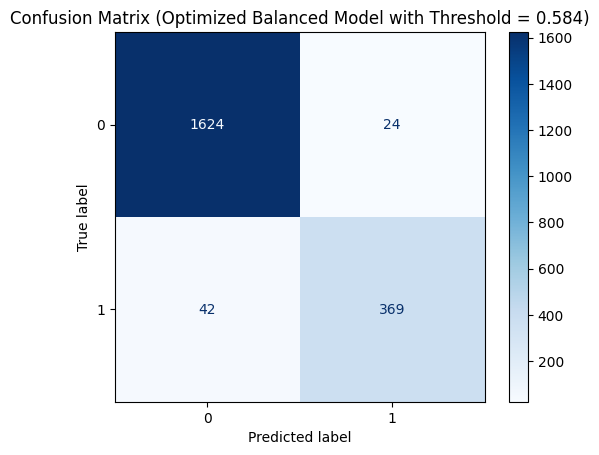

,precision,recall,f1-score,support
0,0.97,0.99,0.98,1648.00
1,0.94,0.90,0.92,411.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.96,0.94,0.95,2059.00
weighted avg,0.97,0.97,0.97,2059.00


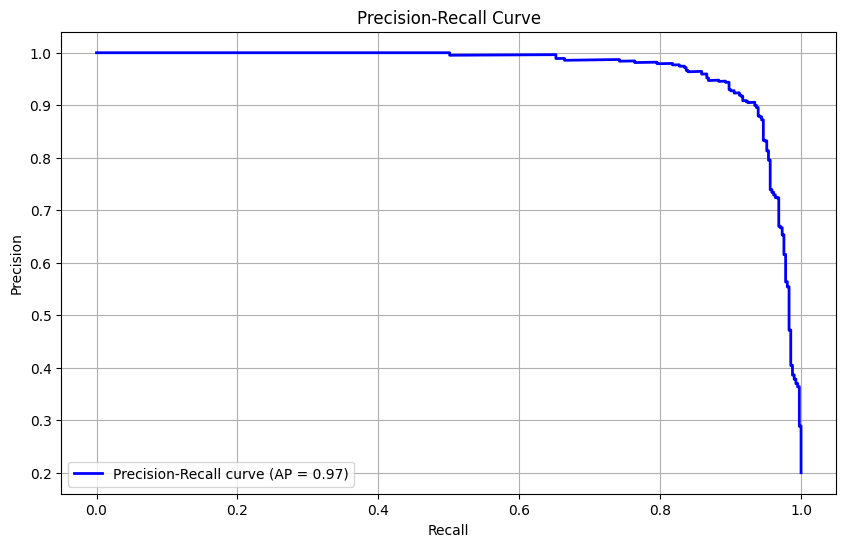

Average Precision (AP) for the Optimized Balanced Model: 0.9679


In [35]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n--- Evaluating Optimized Balanced Model on Test Set with Optimal Threshold ---")

# Assuming model_optimized is defined and fitted
# Assuming X_test_reshaped and y_test are defined

# Optimal threshold identified in cell RZK_m9c_J6-0
optimal_threshold = 0.584 # Update with the value found in cell RZK_m9c_J6-0

# Get predicted probabilities for the positive class on the test set using .predict()
y_proba_optimized = model_optimized.predict(X_test_reshaped).ravel()

# Apply the optimal threshold to get predictions
y_pred_optimal_threshold = (y_proba_optimized >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold - Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal_threshold, cmap=plt.cm.Blues) # Removed display_labels as le is not defined
plt.title(f"Confusion Matrix (Optimized Balanced Model with Threshold = {optimal_threshold:.3f})")
plt.show()

# Evaluate the model with the optimal threshold - Classification Report
report_optimal_threshold = classification_report(y_test, y_pred_optimal_threshold, output_dict=True) # Removed target_names as le is not defined
df_report_optimal_threshold = pd.DataFrame(report_optimal_threshold).transpose()
df_report_optimal_threshold = df_report_optimal_threshold.round(2)
display(df_report_optimal_threshold)

# --- Precision-Recall Curve with AP ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_optimized)
average_precision = average_precision_score(y_test, y_proba_optimized)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Average Precision (AP) for the Optimized Balanced Model: {average_precision:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


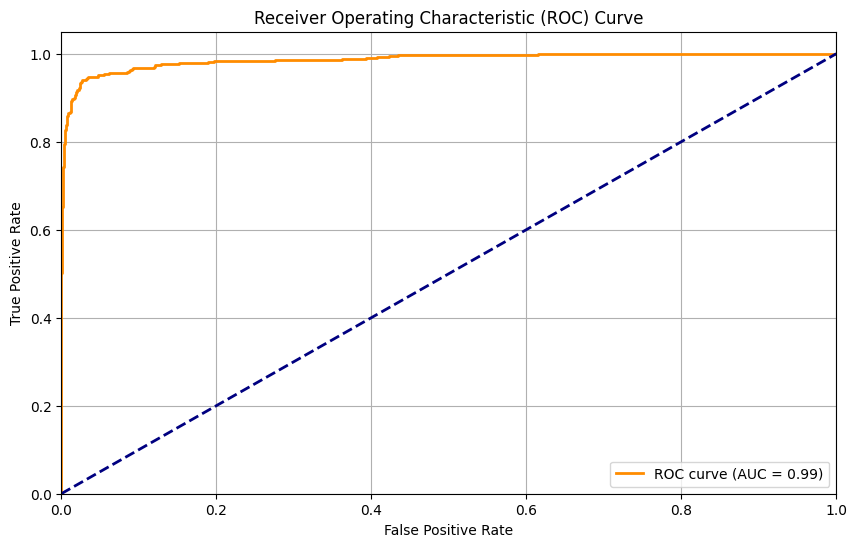

ROC AUC for the Optimized Balanced Model: 0.9867


In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model_optimized is defined and fitted
# Assuming X_test_reshaped and y_test are defined

# Get predicted probabilities for the positive class on the test set
y_proba_optimized = model_optimized.predict(X_test_reshaped).ravel()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_optimized)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC AUC for the Optimized Balanced Model: {roc_auc:.4f}")


--- Evaluating Optimized Balanced Model on Test Set with Optimal Threshold ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


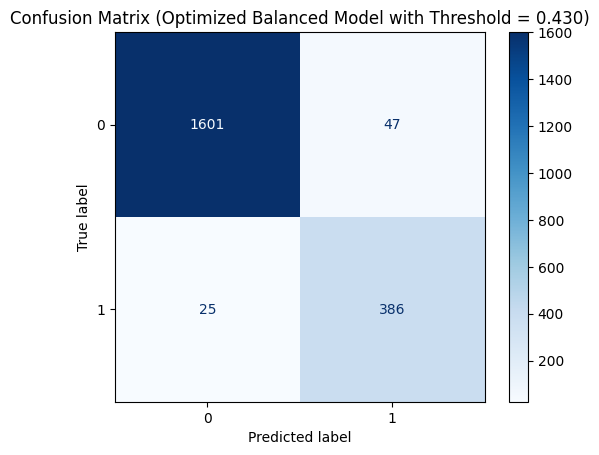

,precision,recall,f1-score,support
0,0.98,0.97,0.98,1648.00
1,0.89,0.94,0.91,411.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.94,0.96,0.95,2059.00
weighted avg,0.97,0.97,0.97,2059.00


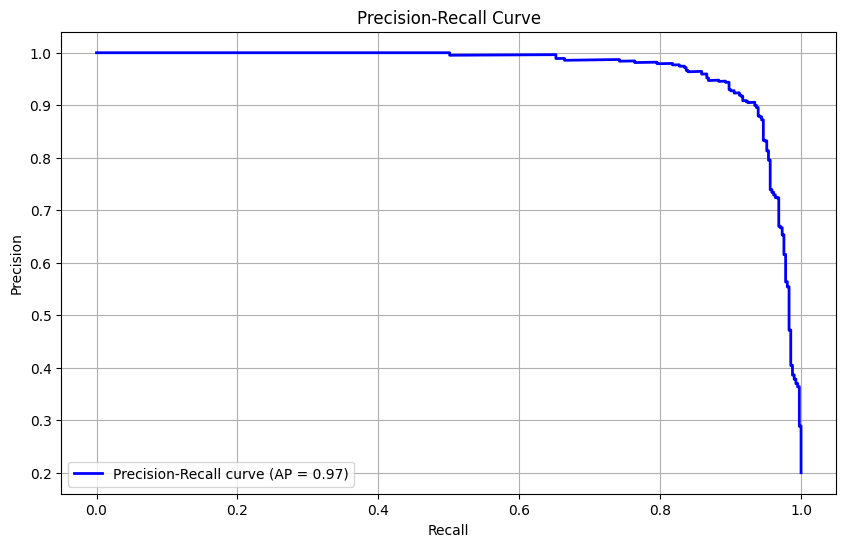

Average Precision (AP) for the Optimized Balanced Model: 0.9679


In [42]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n--- Evaluating Optimized Balanced Model on Test Set with Optimal Threshold ---")

# Assuming model_optimized is defined and fitted
# Assuming X_test_reshaped and y_test are defined

# Optimal threshold identified in cell RZK_m9c_J6-0
optimal_threshold = 0.430 # Update with the value found in cell RZK_m9c_J6-0

# Get predicted probabilities for the positive class on the test set using .predict()
y_proba_optimized = model_optimized.predict(X_test_reshaped).ravel()

# Apply the optimal threshold to get predictions
y_pred_optimal_threshold = (y_proba_optimized >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold - Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal_threshold, cmap=plt.cm.Blues) # Removed display_labels as le is not defined
plt.title(f"Confusion Matrix (Optimized Balanced Model with Threshold = {optimal_threshold:.3f})")
plt.show()

# Evaluate the model with the optimal threshold - Classification Report
report_optimal_threshold = classification_report(y_test, y_pred_optimal_threshold, output_dict=True) # Removed target_names as le is not defined
df_report_optimal_threshold = pd.DataFrame(report_optimal_threshold).transpose()
df_report_optimal_threshold = df_report_optimal_threshold.round(2)
display(df_report_optimal_threshold)

# --- Precision-Recall Curve with AP ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_optimized)
average_precision = average_precision_score(y_test, y_proba_optimized)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Average Precision (AP) for the Optimized Balanced Model: {average_precision:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


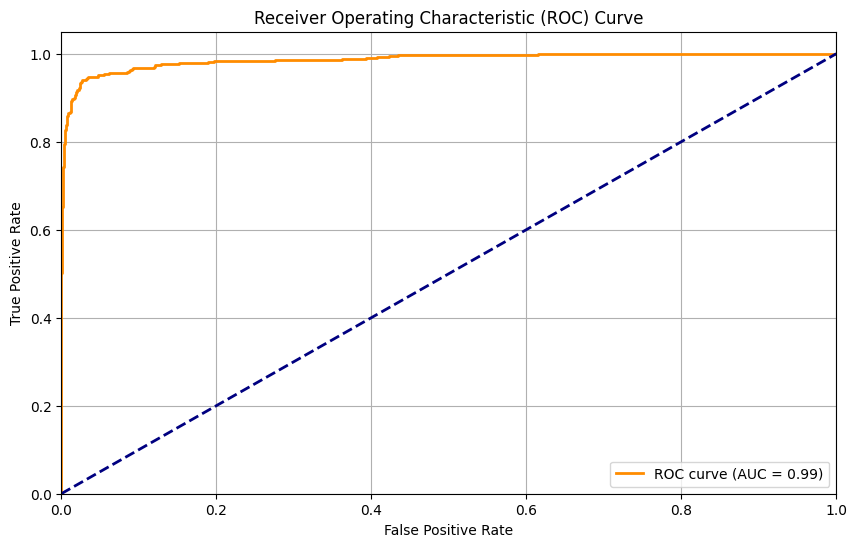

ROC AUC for the Optimized Balanced Model: 0.9867


In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model_optimized is defined and fitted
# Assuming X_test_reshaped and y_test are defined

# Get predicted probabilities for the positive class on the test set
y_proba_optimized = model_optimized.predict(X_test_reshaped).ravel()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_optimized)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC AUC for the Optimized Balanced Model: {roc_auc:.4f}")